In [2]:
import json
with open('schulen.json') as f:
    schulen = json.load(f)

<Axes: >

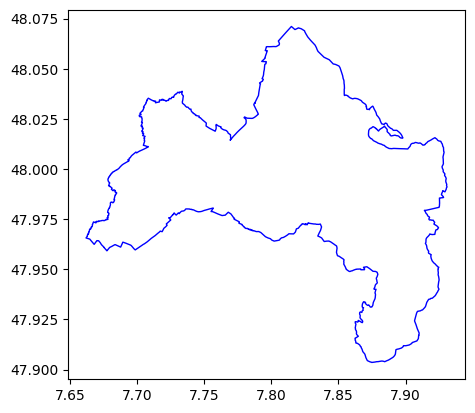

In [3]:
# Read Boundary
# ============
from pyrosm import OSM
from pyrosm import get_data
fp = get_data("freiburg_regbez",directory='pbf/')
# Initialize the OSM parser object
osm = OSM(fp)
bh_bound=osm.get_boundaries(name='Freiburg im Breisgau')
#tags = {'boundary': 'administrative'}   
lk_bh=bh_bound
lk_bh_poly=bh_bound.geometry[0]
lk_bh.plot(facecolor="none", edgecolor="blue")

In [ ]:
bh_bound.plot()

In [5]:
import pyrosm
# Ebene Gemeinde
gem_in_bh_gdf_osm=pyrosm.OSM(filepath="pbf/sk_fr_poly.pbf",bounding_box=lk_bh_poly)
gem_in_bh_gdf_of=gem_in_bh_gdf_osm.get_boundaries(custom_filter={'admin_level': ['8']})
#Filter notwendig, da einige Grenzen außerhalb enthalten waren
in_bh=gem_in_bh_gdf_of.within(lk_bh_poly)

In [18]:
gem_in_bh_gdf=gem_in_bh_gdf_of[ in_bh &  (gem_in_bh_gdf_of['admin_level']=='6') ]  

<Axes: >

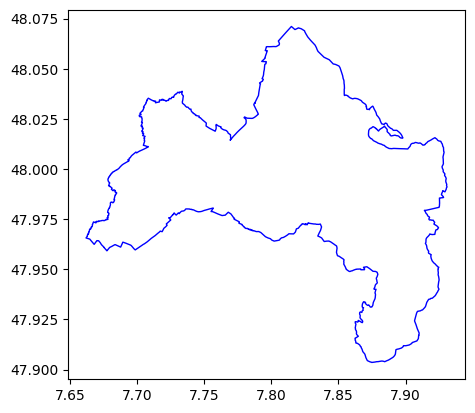

In [19]:
gem_in_bh_gdf.plot(facecolor="none",edgecolor="blue")

In [20]:
len(gem_in_bh_gdf)

1

In [21]:
gem_in_bh_gdf

,name,ref,website,admin_level,boundary,political,postal_code,border_type,start_date,id,timestamp,version,changeset,geometry,tags,osm_type
0,Freiburg im Breisgau,None,None,6,administrative,None,None,None,None,607111,1715031648,176,0,"POLYGON ((7.66279 47.96663, 7.66304 47.96698, ...","{""TMC:cid_58:tabcd_1:Class"":""Area"",""TMC:cid_58...",relation


In [17]:
## Findet alle Teilorte
#in_bh=gem_bh_gdf.within(eki_poly)
#ort_in_bh_gdf=gem_in_bh_gdf_of[ in_bh & (gem_in_bh_gdf_of['boundary']=='administrative') &  ((gem_in_bh_gdf_of['admin_level']=='9')|(gem_in_bh_gdf_of['admin_level']=='10') ) ]  
#len(ort_in_bh_gdf)
gem_in_bh_gdf

,name,ref,website,admin_level,boundary,political,postal_code,border_type,start_date,id,timestamp,version,changeset,geometry,tags,osm_type
17,Oberried,None,None,8,administrative,None,None,None,None,4179002,1694205952,56,0,"POLYGON ((7.90730 47.92321, 7.90778 47.92238, ...","{""TMC:cid_58:tabcd_1:Class"":""Area"",""TMC:cid_58...",relation
66,Bollschweil,None,https://www.bollschweil.de/,8,administrative,None,None,None,None,471469210,1590859208,20,0,"POLYGON ((7.87498 47.90358, 7.87332 47.90395, ...","{""admin_centre:postal_code"":""79283"",""de:amtlic...",relation
85,March,None,None,8,administrative,None,None,None,None,510453409,1580260791,19,0,"MULTIPOLYGON (((7.78693 48.03207, 7.78715 48.0...","{""admin_centre:postal_code"":""79232"",""contact:p...",relation


In [ ]:
######
#
#  Dies ist die Hauptprozedur. 
#  Hier wird über alle Orte iteriert und dabei jeweils zuerst das osm für ein Bereich eingestellt und danach
#  die Wege, Gebäude und Schulen eingetragen und ausgewertet.
#
######
import pandas as pd
import numpy
from shapely.geometry import Point
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib
import osmnx as ox
import datetime

network_type = "walk"
trip_times = [5, 10, 15, 20, 25,30,40]  # in minutes
travel_speed = 3  # walking speed in km/hour
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0)
cmap = matplotlib.cm.cool
norm = matplotlib.colors.BoundaryNorm(trip_times, cmap.N)
place='sk_fr'

sc=[]
for cur in (schulen["schools"]):
    p=Point(cur["lng"],cur["lat"])
    sc=sc+[[p,cur["name"]]]

alle_gem=pd.DataFrame()
for index_gem,row_gem in gem_in_bh_gdf.iterrows():
    gem_name=row_gem['name']
    #if gem_name=='Bollschweil':
    if 1==1:

        print('Line 0036: {} - {}'.format(datetime.datetime.now(),gem_name))
        #gem_poly=row_gem['geometry'].values[0]
        # Initialisierung des Gebiets
        gem_poly=row_gem['geometry']
        #gem_osm=pyrosm.OSM(filepath="pbf/freiburg-regbez-latest.osm.pbf",bounding_box=gem_poly)
        gem_osm=pyrosm.OSM(filepath="pbf/sk_fr_poly.pbf",bounding_box=gem_poly)
        print('Line 0041: {} - {}'.format(datetime.datetime.now(),gem_name))
        # Wegenetz
        gem_walk_net_nodes, gem_walk_net_edges = gem_osm.get_network(network_type="walking",nodes=True)
        gem_walk_net = osm.to_graph(gem_walk_net_nodes, gem_walk_net_edges, graph_type="networkx")
        meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
        for _, _, _, data in gem_walk_net.edges(data=True, keys=True):
            data["time"] = data["length"] / meters_per_minute

        print('Line 0049: {} - {}'.format(datetime.datetime.now(),gem_name))
        
        # Landuse
        tags_lu={'landuse':['residential','farmyard','industrial','commercial']}
        gem_gdf_lu=gem_osm.get_landuse(custom_filter=tags_lu)

        #tags = {'building': True}  
        #gdf_gem_build=ox.features_from_polygon(gem_poly,tags)
        tags = {'addr:housenumber': True}
        
        gdf_gem_hn=gem_osm.get_data_by_custom_criteria(custom_filter=tags)
        
        gdf_gem_hn['triptime']=120
        

        in_gem=gem_poly
        ort_in_bh_gdf=gem_in_bh_gdf_of[ in_bh & (gem_in_bh_gdf_of['boundary']=='administrative') &  ((gem_in_bh_gdf_of['admin_level']=='9')|(gem_in_bh_gdf_of['admin_level']=='10') ) ]  
        
        # Ortsteile: 
        in_gem=gem_in_bh_gdf_of.within(gem_poly)
        ort_in_gem_gdf=gem_in_bh_gdf_of[ in_gem & (gem_in_bh_gdf_of['boundary']=='administrative') &  ((gem_in_bh_gdf_of['admin_level']=='9')|(gem_in_bh_gdf_of['admin_level']=='10') ) ]  

        # Aufbau Listen:     
        t=pd.DataFrame({'GemName':[gem_name]})
        x=ort_in_gem_gdf['name'].values
        if gem_name not in x:
            x=numpy.append(x,[[gem_name]])
        ort=pd.DataFrame({'OrtName': x})
        #ort=pd.DataFrame[{'Name':x[0]}]
        y=numpy.unique(gem_gdf_lu['landuse'].values)
        y=numpy.append(y,[['unbekannt']])
        #y.append('unbekannt')
        landuse_df=pd.DataFrame({'Landuse': y})
        tt=pd.DataFrame({'WegeDauer':[0]+trip_times+[120]})
        
        res=pd.merge(ort,landuse_df, how='cross')
        res2=pd.merge(t,res, how='cross')
        boxen=pd.merge(res2,tt, how='cross')
        boxen=boxen.set_index(['GemName','OrtName','Landuse','WegeDauer'])
        boxen['Anzahl']=0
            
        print('Line 0088: {} - {}'.format(datetime.datetime.now(),gem_name))
        
        node_colors = {}
        node_time = {}
        for cur in (schulen["schools"]):
            p=Point(cur["lng"],cur["lat"])
            if p.within(gem_poly): 
                poi=ox.distance.nearest_nodes(gem_walk_net, cur["lng"],cur["lat"])
                for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
                    subgraph = nx.ego_graph(gem_walk_net, poi, radius=trip_time, distance="time")
                    for node in subgraph.nodes():
                        col_old=0
                        if node in node_colors:
                            col_old=sum(node_colors[node])
                        if sum(color)>col_old:
                            node_colors[node] = color
                        col_time=10000000
                        if node in node_time:
                            col_time=node_time[node]
                        if trip_time<col_time:
                            node_time[node] = trip_time    
        print('Line 0113: {} - {}'.format(datetime.datetime.now(),gem_name))

        for idx_build, row_build in gdf_gem_hn.iterrows():
            poly_build=row_build['geometry']
            #poly_ort = gpd.GeoSeries(row_orte['geometry'])
            p_center=poly_build.centroid
            poi=ox.distance.nearest_nodes(gem_walk_net, p_center.x,p_center.y)
            WegeDauer=120
            if poi in node_time:
                WegeDauer=node_time[poi]
            if poi in node_time:
                gdf_gem_hn.loc[idx_build,['triptime']]=node_time[poi]
            
            Landuse='unbekannt'
            for idx_landuse, row_landuse in gem_gdf_lu.iterrows():
                lu_type=row_landuse['landuse']
                poly_lu= gpd.GeoSeries(row_landuse['geometry'])
                if poly_lu.contains(p_center).any():
                    Landuse=lu_type
                    break
            Ortsteil=gem_name
            for idx_ort, row_ort in ort_in_gem_gdf.iterrows():
                poly_ortt = gpd.GeoSeries(row_ort['geometry'])
                if poly_ortt.contains(p_center).any():
                    Ortsteil=row_ort['name']
                    break
            boxen.at[(gem_name,Ortsteil,Landuse,WegeDauer),'Anzahl']=boxen.at[(gem_name,Ortsteil,Landuse,WegeDauer),'Anzahl']+1
        print('Line 0139: {} - {}'.format(datetime.datetime.now(),gem_name))
    
        boxen.to_csv('erstellte_daten/'+gem_name+'.csv',index=True)
        if len(alle_gem)<5:
            alle_gem=boxen
        else:
            alle_gem=alle_gem+boxen
        alle_gem.to_csv('erstellte_daten/'+place+'.csv',index=True)

        br=1
        anz=1

        gp_b=gem_poly.bounds[2]-gem_poly.bounds[0]
        gp_l=gem_poly.bounds[3]-gem_poly.bounds[1]
        md=max(gp_b,gp_l)
        size=60/md


        print('Line 0151: {} - {}'.format(datetime.datetime.now(),gem_name))
     
        fig, axs = plt.subplots(anz,br,figsize=(int(gp_b*size), int(gp_l*size)))
        #fig, axs = plt.subplots(anz,br)
        axs.set_title(gem_name)
        gem_gdf_lu.plot(ax=axs,column='landuse', facecolor='none',legend=True)
        for idx_orte, row_orte in ort_in_gem_gdf.iterrows():
            poly_ort = gpd.GeoSeries(row_orte['geometry'])
            p_center=poly_ort.centroid
            if gem_poly.contains(p_center).any():
                poly_ort.plot(ax=axs,facecolor='none', edgecolor='green')
                axs.annotate(text=row_orte["name"], xy=(p_center[0].x,p_center[0].y), horizontalalignment='center')
        if len(ort_in_gem_gdf)==0:
            gem_poly_gpd = gpd.GeoSeries(gem_poly)
            gem_poly_gpd.plot(ax=axs,facecolor='none', edgecolor='blue') 
        gdf_gem_hn.plot(ax=axs,column='triptime',markersize =5, cmap=cmap,norm=norm)
        #nc = [node_colors[node] if node in node_colors else "none" for node in gdf_gem_walk.nodes()]
        #ns = [5 if node in node_colors else 0 for node in gdf_gem_walk.nodes()]
        #poly_ort.plot(ax=axs,facecolor='none', edgecolor='green')
        fig, ax = ox.plot_graph(
            gem_walk_net,
            ax=axs,
            #node_color=nc,
            #node_size=ns,
            node_alpha=0.8,
            edge_linewidth=0.2,
            edge_color="#999999",
            show=False, 
            close=False
        )
        for cur in sc:
            axs.scatter(cur[0].x,cur[0].y,color='red',s=80)    
            axs.annotate(text=cur[1], xy=(cur[0].x,cur[0].y), horizontalalignment='center')
            #axs[sw//br,sw%br].set_ylim(poly_gem.bounds["miny"][0],poly_gem.bounds["maxy"][0])
            #axs[sw//br,sw%br].set_xlim(poly_gem.bounds["minx"][0],poly_gem.bounds["maxx"][0])
        plt.savefig('images/'+gem_name+'.png')
        #plt.show()



Line 0036: 2024-08-20 16:50:29.005747 - Freiburg im Breisgau
Line 0041: 2024-08-20 16:50:29.013039 - Freiburg im Breisgau
Line 0049: 2024-08-20 16:51:06.753071 - Freiburg im Breisgau
Line 0088: 2024-08-20 16:51:10.843630 - Freiburg im Breisgau


In [ ]:
(int(gp_b*size), int(gp_l*size))

In [ ]:
#hn_colors_series = pd.DataFrame.from_dict(hn_colors,orient='index')
#hn_colors_series

colors = map(lambda x: hn_colors.get(x, (0.5,0.5,0.5,1)), gdf_gem_hn.index.get_level_values(1))

In [ ]:
#hn_colors
for cur in gdf_gem_hn.index:
    osmid =cur[1] 
    #print (cur[1])
    if osmid in hn_colors:
        print(hn_colors[osmid])